In [ ]:
# import der notwendigen Bibliotheken

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import Lab2Functions as ekg

In [ ]:
# Filterung der Daten, um Ausreißer zu entfernen

data = {
    "Elias": pd.read_csv('Daten_L2/arduino_log_Elias.csv', sep=";", index_col=0),
    "Lasse": pd.read_csv('Daten_L2/arduino_log_Lasse.csv', sep=";", index_col=0),
    "Hauke": pd.read_csv('Daten_L2/arduino_log_Hauke.csv', sep=";", index_col=0),
    "with_charger": pd.read_csv('Daten_L2/data_with_charger.csv', sep=";", index_col=0),
    "without_charger":  pd.read_csv('Daten_L2/data_without_charger.csv', sep=";", index_col=0),
    "with_charger_and_touch": pd.read_csv('Daten_L2/data_with_charger_and_touch.csv', sep=";", index_col=0)
}

names = [name for name in data]

for name, df in data.items():
    max_threshold = 1000
    filter_mask = df['value'] <= max_threshold
    data[name] = df[filter_mask]

In [56]:
def color_graph(time, ecg_signal, QRS_start, QRS_end, T_start, T_end, P_start, P_end):
    Baseline_color = '#CCCCCC'
    p_pos_index = int((P_start+P_end)/2)
    qrs_r_pos_index = int((QRS_start+QRS_end)/2)
    t_pos_index = int((T_start+T_end)/2)

    plt.plot(time, ecg_signal, color=Baseline_color, linewidth=2)
    plt.plot(time[P_start:P_end], ecg_signal[P_start:P_end],
             color='red', linewidth=3)
    plt.plot(time[QRS_start:QRS_end],
             ecg_signal[QRS_start:QRS_end], color='green', linewidth=3)
    plt.plot(time[T_start:T_end], ecg_signal[T_start:T_end],
             color='orange', linewidth=3)

    # 4. Textbeschriftung direkt am Graphen (oberhalb der Peaks)
    text_offset_y = 2  # Kleiner vertikaler Abstand über dem Peak

    # P-Welle

    y_P = max(ecg_signal[P_start:P_end]) + text_offset_y
    plt.text(time[p_pos_index], y_P, 'P', color='red',
             fontsize=14, fontweight='bold', ha='center')

    # QRS-Komplex (R-Peak)
    y_QRS = max(ecg_signal[QRS_start:QRS_end]) + text_offset_y
    plt.text(time[qrs_r_pos_index], y_QRS, 'QRS', color='green',
             fontsize=14, fontweight='bold', ha='center')

    # T-Welle
    y_T = max(ecg_signal[T_start:T_end]) + text_offset_y
    plt.text(time[t_pos_index], y_T, 'T', color='orange',
             fontsize=14, fontweight='bold', ha='center')

    # Achsenbeschriftungen und Titel
    plt.xlabel('Zeit (ms)')
    plt.ylabel('Amplitude')
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.ylim(min(ecg_signal) - 0.2, max(ecg_signal) + 0.3)  # Y-Achse angepasst
    plt.show()


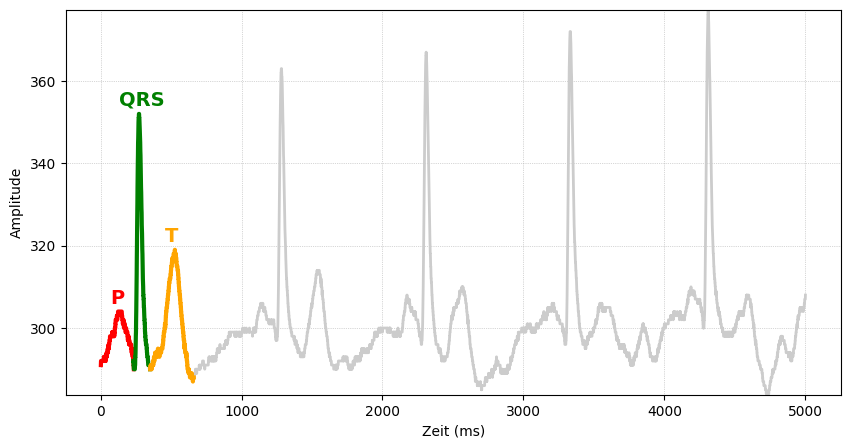

In [57]:
def create_plot(name):
    ecg_signal = data[name]["value"][5000:10000].to_list()
    time = data[name].index[:5000].to_list()

    # 3. Plot erstellen, Segmente farbig zeichnen und Text hinzufügen
    plt.figure(figsize=(10, 5))

    # Basislinie und Segmente (wie im vorherigen Beispiel)
    QRS_starts = [230]
    QRS_ends = [350]
    T_starts = [350]
    T_ends = [660]
    P_start = 0
    P_end = 235

    for i in range(len(QRS_starts)):
        color_graph(time, ecg_signal, QRS_starts[i], QRS_ends[i],
                    T_starts[i], T_ends[i], P_start, P_end)

create_plot("Elias")

In [58]:
def analyse(name):
    """Analysiere ECG-Daten und berechne HF und HRV"""

    ecg = data[name]["value"]
    time = pd.Series(np.arange(len(ecg)))

    d_ECG, peaks_d_ecg = ekg.decg_peaks(ecg, time)
    Rwave_peaks_d_ecg, threshold = ekg.d_ecg_peaks(
        d_ECG, peaks_d_ecg, time, 1, 0.2)
    Rwave_t = ekg.Rwave_peaks(ecg, d_ECG, Rwave_peaks_d_ecg, time)

    sampling_rate = 1000  # Hz
    RR_intervals = np.diff(Rwave_t)
    RR_intervals_seconds = RR_intervals / sampling_rate
    mean_RR_interval = np.mean(RR_intervals_seconds)
    heart_rate_bpm = 60 / mean_RR_interval
    hrv = (np.std(RR_intervals_seconds))*1000  # in ms

    return heart_rate_bpm, hrv, Rwave_t

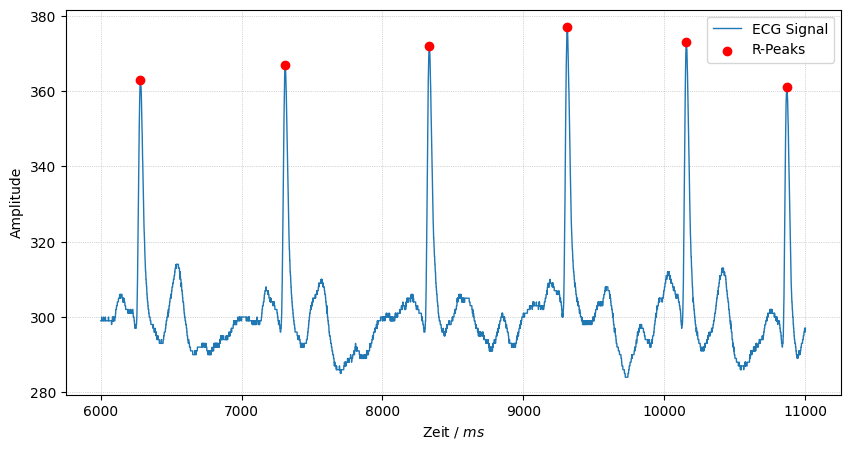

In [59]:
def plot_ecg_with_rwaves(name, Rwave_t):
    ecg_signal = data[name]["value"].to_list()
    time = data[name].index.to_list()

    # Zeitraum definieren
    start_idx = 6000
    end_idx = 11000
    
    # Daten für den gewünschten Zeitraum extrahieren
    time_range = time[start_idx:end_idx]
    ecg_range = ecg_signal[start_idx:end_idx]
    
    # R-Peaks im Zeitraum filtern
    mask = (Rwave_t >= start_idx) & (Rwave_t < end_idx)
    rwave_indices = Rwave_t[mask]
    
    plt.figure(figsize=(10, 5))
    plt.plot(time_range, ecg_range, color='#1f77b4', linewidth=1, label='ECG Signal')
    plt.scatter([time[i] for i in rwave_indices], [ecg_signal[i] for i in rwave_indices],
                color='red', label='R-Peaks', zorder=5)
    plt.xlabel('Zeit / $ms$')
    plt.ylabel('Amplitude')
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.legend(loc = 'upper right')
    #plt.savefig(f'../Bericht2_Biosignalverarbeitung/figures/ecg_with_rwaves_{name}.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_ecg_with_rwaves("Elias", analyse("Elias")[2])

In [60]:
# Berechnung des geschätzten Energieverbrauchs für jede Person

person_data = {
    "Elias": {"age": 21, "weight": 73},
    "Lasse": {"age": 19, "weight": 58},
    "Hauke": {"age": 21, "weight": 77}
}

results = {}
for name in ["Elias", "Lasse", "Hauke"]:
    heart_rate, hrv, Rwave_t = analyse(name)
    age = person_data[name]["age"]
    weight = person_data[name]["weight"]
    # Energieverbrauch in kcal/min (vereinfachte Formel)
    #hrr = heart_rate - (208 - 0.7 * age)
    #energy_expenditure = 0.449+0.0627*hrr+0.00743*weight+0.001*hrr*weight # in kcal/minute Model one from given paper for man and low activity
    energy_expenditure = 4.56 - 0.0265*heart_rate -0.1506*weight + 0.00189*heart_rate*weight  # in kcal/minute Model one from given paper and low activity
    
    results[name] = {
        "Heart Rate (bpm)": float(heart_rate),
        "HRV (ms)": float(hrv),
        "Estimated Energy Expenditure (kcal/min)": float(energy_expenditure),
        "Estimated Energy Expenditure * duration (kcal)": float(energy_expenditure * 10)  # assuming 10 minutes of activity
    }
    print(results[name])


{'Heart Rate (bpm)': 68.04319342158767, 'HRV (ms)': 83.23009021201247, 'Estimated Energy Expenditure (kcal/min)': 1.1509747707043783, 'Estimated Energy Expenditure * duration (kcal)': 11.509747707043783}
{'Heart Rate (bpm)': 73.443347650265, 'HRV (ms)': 57.50744434269284, 'Estimated Energy Expenditure (kcal/min)': 1.929811056690026, 'Estimated Energy Expenditure * duration (kcal)': 19.29811056690026}
{'Heart Rate (bpm)': 60.20977931457348, 'HRV (ms)': 113.3538758380124, 'Estimated Energy Expenditure (kcal/min)': 0.13057003181367932, 'Estimated Energy Expenditure * duration (kcal)': 1.3057003181367932}


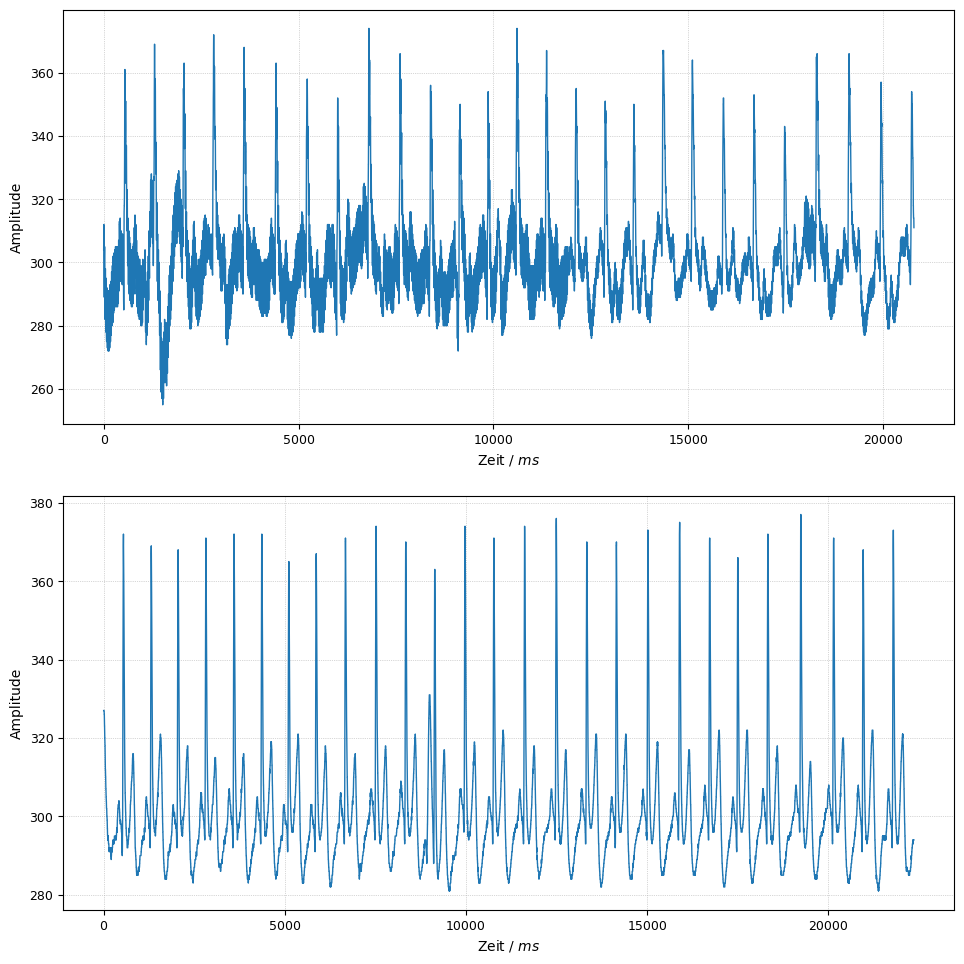

In [61]:
def create_serial_plotter_plots():
    fig, axes = plt.subplots(2, 1, figsize=(10, 10)) # 2 Zeilen, 1 Spalte
    
    for idx, name in enumerate(["with_charger", "with_charger_and_touch"]):
        ecg_signal = data[name]["value"].to_list()
        time = data[name].index.to_list()

        axes[idx].plot(time, ecg_signal, color='#1f77b4', linewidth=1)
        axes[idx].set_xlabel('Zeit / $ms$', fontsize=10)
        axes[idx].set_ylabel('Amplitude', fontsize=10)
        #axes[idx].set_title(f'ECG Signal - {name.replace("_", " ").title()}', fontsize=12, fontweight='bold', pad=15)
        axes[idx].grid(True, which='both', linestyle=':', linewidth=0.5)
        #axes[idx].set_ylim(min(ecg_signal) - 0.2, max(ecg_signal) + 0.3)
        axes[idx].tick_params(axis='both', which='major', labelsize=9)
    
    plt.tight_layout(pad=2.0)
    #plt.savefig('../Bericht2_Biosignalverarbeitung/figures/ecg_plots_with_and_without_charger.png', dpi=300, bbox_inches='tight')
    plt.show()

create_serial_plotter_plots()

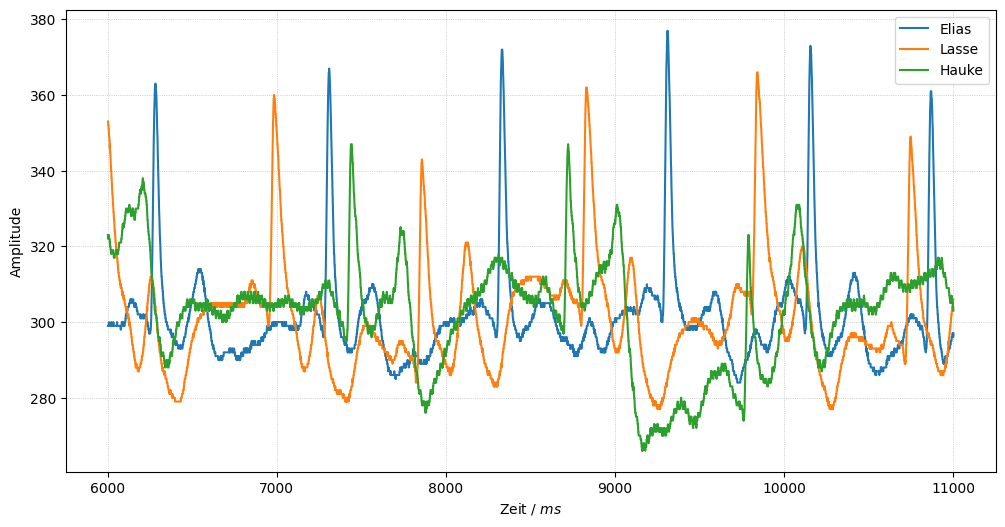

In [62]:
def plot_of_all_participants():
    plt.figure(figsize=(12, 6))

    for name in ["Elias", "Lasse", "Hauke"]:
        ecg_signal = data[name]["value"][6000:11000].to_list()
        time = data[name].index[6000:11000].to_list()

        plt.plot(time, ecg_signal, label=name)

    plt.xlabel('Zeit / $ms$')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    # plt.savefig('../Bericht2_Biosignalverarbeitung/figures/ecg_plots_all_participants.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_of_all_participants()

Geladene Datenpunkte: 567445
Zeitbereich: 2 - 567446 ms
Signal-Bereich: 0.00 - 657.00 mV
Gefundene d_ECG Peaks: 131059
Versuch 1 fehlgeschlagen: `distance` must be greater or equal to 1
Versuch 2 erfolgreich: 868 R-Wave Peaks gefunden

Anzahl R-Peaks: 867
Anzahl RR-Intervalle (nach Filterung): 475

✅ Ergebnisse:
Anzahl Fenster-Werte: 469
Mittlere HR: 86.78 bpm
HRV: 343.97 ms
Zeit-Bereich: 2890.00 - 514395.00 ms
HR-Bereich: 45.05 - 169.08 bpm
Mittelwerte -> Ruhe: 64.8, Belastung: 119.7, Erholung: 82.0


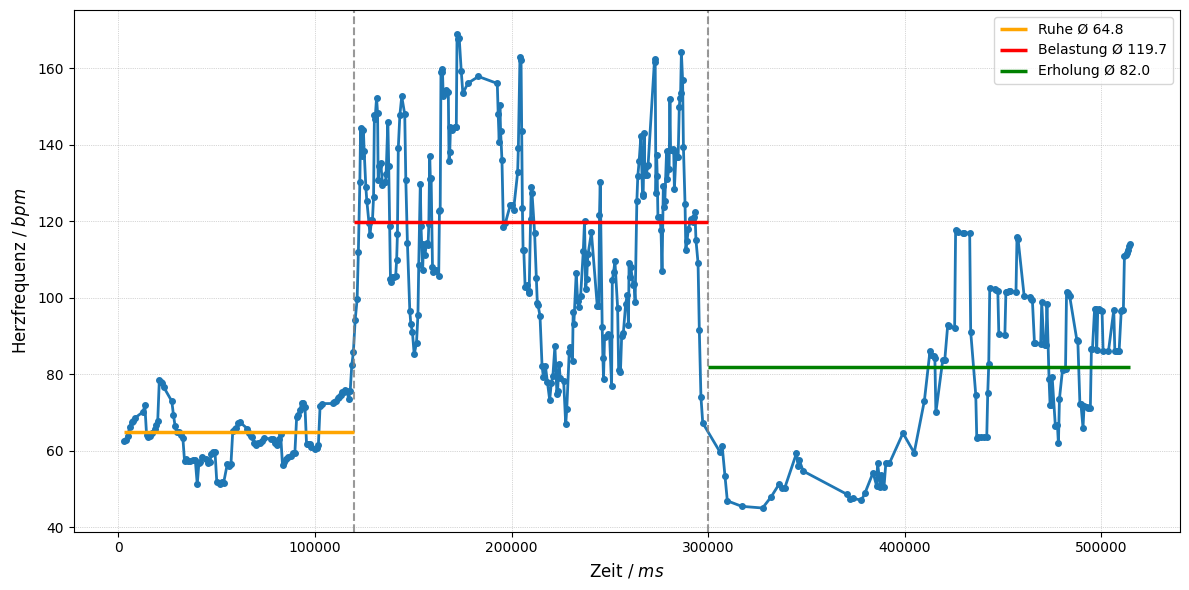

(np.float64(86.77965275959296), np.float64(343.9687824912776))

In [63]:
def analyze_ecg_and_plot(file_path, window_size=10):
    """Analysiere ECG-Daten und erstelle Plot der Herzfrequenz mit gleitendem Fenster

    Parameters:
    -----------
    file_path : str
        Pfad zur ECG-Datei
    window_size : int
        Anzahl der R-R-Intervalle für die Fensterberechnung (default: 10)
    """

    # Daten laden - als Pandas Series für Kompatibilität
    df = pd.read_csv(file_path, sep=';')
    ecg = df['value']  # Als Pandas Series behalten!
    time = pd.Series(df['index'].values)  # Als Series

    print(f"Geladene Datenpunkte: {len(ecg)}")
    print(f"Zeitbereich: {time.iloc[0]} - {time.iloc[-1]} ms")
    print(f"Signal-Bereich: {ecg.min():.2f} - {ecg.max():.2f} mV")

    # ECG-Analyse mit angepassten Parametern
    d_ECG, peaks_d_ecg = ekg.decg_peaks(ecg, time)

    print(f"Gefundene d_ECG Peaks: {len(peaks_d_ecg)}")

    # Versuche Peak-Detection mit verschiedenen Parametern
    try:
        # Erste Versuche mit moderaten Werten
        Rwave_peaks_d_ecg, threshold = ekg.d_ecg_peaks(
            d_ECG, peaks_d_ecg, time, 0.01, 0.1)
        print(
            f"Versuch 1 erfolgreich: {len(Rwave_peaks_d_ecg)} R-Wave Peaks gefunden")
    except Exception as e:
        print(f"Versuch 1 fehlgeschlagen: {e}")
        try:
            # Zweiter Versuch mit niedrigeren Schwellen
            Rwave_peaks_d_ecg, threshold = ekg.d_ecg_peaks(
                d_ECG, peaks_d_ecg, time, 0.3, 0.15)
            print(
                f"Versuch 2 erfolgreich: {len(Rwave_peaks_d_ecg)} R-Wave Peaks gefunden")
        except Exception as e2:
            print(f"Versuch 2 fehlgeschlagen: {e2}")
            try:
                # Dritter Versuch mit sehr niedrigen Schwellen
                Rwave_peaks_d_ecg, threshold = ekg.d_ecg_peaks(
                    d_ECG, peaks_d_ecg, time, 0.2, 0.1)
                print(
                    f"Versuch 3 erfolgreich: {len(Rwave_peaks_d_ecg)} R-Wave Peaks gefunden")
            except Exception as e3:
                print(f"Versuch 3 fehlgeschlagen: {e3}")
                print("\n❌ Alle Peak-Detection Versuche fehlgeschlagen!")
                print("Das Signal ist vermutlich zu verrauscht oder beschädigt.")
                return None, None

    # R-Wave Peaks extrahieren
    try:
        Rwave_t = ekg.Rwave_peaks(ecg, d_ECG, Rwave_peaks_d_ecg, time)
    except Exception as e:
        print(f"❌ Fehler bei Rwave_peaks: {e}")
        return None, None

    sampling_rate = 1000  # Hz

    # Rwave_t in numpy array konvertieren für einfachere Handhabung
    Rwave_t_values = Rwave_t.values

    RR_intervals = np.diff(Rwave_t_values)
    RR_intervals_seconds = RR_intervals / sampling_rate

    # Filtern von unrealistischen RR-Intervallen (< 0.3s oder > 2s)
    valid_mask = (RR_intervals_seconds > 0.3) & (RR_intervals_seconds < 2.0)
    RR_intervals_seconds = RR_intervals_seconds[valid_mask]

    print(f"\nAnzahl R-Peaks: {len(Rwave_t)}")
    print(
        f"Anzahl RR-Intervalle (nach Filterung): {len(RR_intervals_seconds)}")

    if len(RR_intervals_seconds) < 3:
        print("\n⚠️ WARNUNG: Zu wenige valide RR-Intervalle!")
        return None, None

    # Prüfen ob genug Daten vorhanden sind
    if len(RR_intervals_seconds) < window_size:
        print(f"\nWARNUNG: Nur {len(RR_intervals_seconds)} RR-Intervalle!")
        window_size = max(1, len(RR_intervals_seconds))

    # Herzfrequenz mit gleitendem Fenster berechnen
    windowed_hr = []
    windowed_times = []

    # Angepasste Zeitpunkte für gefilterte Daten - ALS NUMPY ARRAY!
    valid_peak_times = Rwave_t_values[:-1][valid_mask]

    for i in range(len(RR_intervals_seconds) - window_size + 1):
        window = RR_intervals_seconds[i:i+window_size]
        mean_RR = np.mean(window)
        hr = 60 / mean_RR
        windowed_hr.append(hr)
        # Jetzt funktioniert der Zugriff, weil valid_peak_times ein numpy array ist
        windowed_times.append(valid_peak_times[i + window_size//2])

    windowed_hr = np.array(windowed_hr)
    windowed_times = np.array(windowed_times)

    # Gesamtdurchschnittswerte
    mean_RR_interval = np.mean(RR_intervals_seconds)
    heart_rate_bpm = 60 / mean_RR_interval
    hrv = (np.std(RR_intervals_seconds)) * 1000  # in ms

    print(f"\n✅ Ergebnisse:")
    print(f"Anzahl Fenster-Werte: {len(windowed_hr)}")
    print(f"Mittlere HR: {heart_rate_bpm:.2f} bpm")
    print(f"HRV: {hrv:.2f} ms")

    if len(windowed_hr) > 0:
        print(
            f"Zeit-Bereich: {windowed_times.min():.2f} - {windowed_times.max():.2f} ms")
        print(
            f"HR-Bereich: {windowed_hr.min():.2f} - {windowed_hr.max():.2f} bpm")

        # Plot erstellen

        plt.figure(figsize=(12, 6))

        plt.plot(windowed_times, windowed_hr, marker='o', linestyle='-',
                 linewidth=2, markersize=4, color='#1f77b4')

        # --- Zeitgrenzen definieren (in ms) ---
        t_rest_end = 120 * 1000        # 120 Sekunden
        t_test_end = (120 + 180) * 1000   # 300 Sekunden

        # Indizes im Zeit-Array finden
        idx_rest = np.searchsorted(windowed_times, t_rest_end)
        idx_test = np.searchsorted(windowed_times, t_test_end)

        # --- Mittelwerte berechnen ---
        # Ruhephase (Start bis 120s)
        if idx_rest > 0:
            mean_resting = np.mean(windowed_hr[:idx_rest])
        else:
            mean_resting = np.nan

        # Belastungsphase (120s bis 300s)
        if idx_test > idx_rest:
            mean_test = np.mean(windowed_hr[idx_rest:idx_test])
        else:
            mean_test = np.nan

        # Erholungsphase (300s bis Ende)
        if len(windowed_hr) > idx_test:
            mean_end = np.mean(windowed_hr[idx_test:])
        else:
            mean_end = np.nan

        print(
            f"Mittelwerte -> Ruhe: {mean_resting:.1f}, Belastung: {mean_test:.1f}, Erholung: {mean_end:.1f}")

        # --- Vertikale Trennlinien - --
        plt.axvline(t_rest_end, color='gray', linestyle='--', alpha=0.8)
        plt.axvline(t_test_end, color='gray', linestyle='--', alpha=0.8)

        # --- Horizontale Durchschnittslinien(mit hlines für exakte Länge) - --
        t_start = windowed_times[0]
        t_end_meas = windowed_times[-1]

        # 1. Ruhephase
        if not np.isnan(mean_resting):
            plt.hlines(y=mean_resting, xmin=t_start, xmax=t_rest_end,
                       colors='orange', linewidth=2.5, label=f'Ruhe Ø {mean_resting:.1f}')

        # 2. Belastung
        if not np.isnan(mean_test):
            # xmax ist entweder 300s oder das Ende der Messung, falls früher
            xmax_test = min(t_test_end, t_end_meas)
            plt.hlines(y=mean_test, xmin=t_rest_end, xmax=xmax_test,
                       colors='red', linewidth=2.5, label=f'Belastung Ø {mean_test:.1f}')

        # 3. Erholung
        if not np.isnan(mean_end) and t_end_meas > t_test_end:
            plt.hlines(y=mean_end, xmin=t_test_end, xmax=t_end_meas,
                       colors='green', linewidth=2.5, label=f'Erholung Ø {mean_end:.1f}')

        plt.xlabel('Zeit / $ms$', fontsize=12)
        plt.ylabel('Herzfrequenz / $bpm$', fontsize=12)
        plt.grid(True, which='both', linestyle=':', linewidth=0.5)
        plt.legend()
        plt.tight_layout()
        #plt.savefig('../Bericht2_Biosignalverarbeitung/figures/windowed_hr_with_averages.png',
        #            dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("\n❌ Keine Daten zum Plotten!")

    return heart_rate_bpm, hrv


# Verwendung:
analyze_ecg_and_plot(
    'Daten_L2/arduino_log_belastung.csv', window_size=7)

In [64]:
def calculateenergy(gesamt_energie_kcal):
    """
    Funktion rechnet den metabolischen Energieverbrauch aus Lab2functions.py um in alternative Einheiten
    - Joule 
    - Kilokalorien (kcal)
    - Rittersporttafeln (100g Tafel = 541 kcal)
    - Bier (0.5l Glas = 210 kcal)
    - Anteil am Tagesbedarf von Lasse
    """
    gewicht_lasse = 59  # kg
    groesse_lasse = 178  # cm
    alter_lasse = 19  # Jahre
    tagesbedarf_lasse_kcal = (66.47+(13.75*gewicht_lasse)+(5*groesse_lasse)-(6.755*alter_lasse))*1.375 

    # Umrechnung in Joule
    energie_joule = gesamt_energie_kcal * 4184  # 1 kcal = 4184 Joule

    # Umrechnung in Kilokalorien (kcal)
    energie_kcal = gesamt_energie_kcal  # bereits in kcal

    # Umrechnung in Rittersporttafeln (100g Tafel = 541 kcal)
    energie_rittersport = energie_kcal / 541

    # Umrechnung in Bier (0.5l Glas = 210 kcal)
    energie_bier = energie_kcal / 210

    # Anteil am Tagesbedarf von Lasse (ca. 2500 kcal pro Tag)
    anteil_tagesbedarf = (energie_kcal / tagesbedarf_lasse_kcal) * 100  # in Prozent

    print("Joule:", energie_joule,
        "Kilokalorien:", energie_kcal,
        "Rittersporttafeln:", energie_rittersport,
        "Bier (0.5l Gläser):", energie_bier,
        "Anteil am Tagesbedarf (%):", anteil_tagesbedarf
    )